### Load packages

In [ ]:
import pandas as pd
import numpy as np
import string
from collections import Counter
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import csv

import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight

In [ ]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

### Set up hyperparameters

In [ ]:
embedding_dim = 50
trunc_type ='post'
padding_type ='post'
oov_tok = "<OOV>"
training_portion = .80
num_epochs = 10

### function definitions

In [ ]:
def load_data(filename):
    df = pd.read_csv(filename).fillna("None")
    text = df['NARRATIVE']
    labels = df['CRIMETYPE']
    softmax_layer = len(set(labels))
    return list(text), list(labels), softmax_layer

def generate_class_weights(class_series):
    # Compute class weights with sklearn method
    class_labels = np.unique(class_series)
    class_weights = compute_class_weight(class_weight='balanced', classes=class_labels, y=class_series)

    return dict(zip(class_labels, class_weights))

def label_categorize(labels):
    le = LabelEncoder()
    le.fit(labels)
    label_seq = le.transform(labels)

    return label_seq

def create_tokens(text):
    token_list = []
    stop_words = set(stopwords.words('english'))
    for i in range(len(text)):
        token_list.append(word_tokenize(text[i].lower()))
        token_list[i] = [w for w in token_list[i] if not w in stop_words]

    return token_list

def Generate_Train_Validation(token_list, label_seq):
    train_size = int(len(token_list) * training_portion)

    train_seqs = token_list[:train_size]
    validation_seqs = token_list[train_size:]

    tokenizer = Tokenizer(oov_token=oov_tok)
    tokenizer.fit_on_texts(train_seqs)
    word_index = tokenizer.word_index
    vocab_size = len(word_index) + 1

    train_sequences = tokenizer.texts_to_sequences(train_seqs)
    train_padded = pad_sequences(train_sequences, padding=padding_type)
    max_length = len(train_padded[0])

    validation_sequences = tokenizer.texts_to_sequences(validation_seqs)
    validation_padded = pad_sequences(validation_sequences, padding=padding_type, maxlen=max_length)

    output = []
    for v in label_seq:
        output.append([v])

    train_label_seq = np.array(output[:train_size])
    validation_label_seq = np.array(output[train_size:])

    train_label_list = label_seq[:train_size]
    class_weights = generate_class_weights(train_label_list)

    return train_padded, train_label_seq, validation_padded, validation_label_seq, class_weights

def decode_labels(encoded_predict_labels, le):
    test_predictions = le.inverse_transform(encoded_predict_labels)
    
    return test_predictions

def get_seq_ids(filename):
    df = pd.read_csv(filename)
    ids = df['id']
    
    return np.array(ids)

def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

### Generate embeddings of text data using tokenizer

In [ ]:
filename = "train.csv"
text, labels, softmax_layer = load_data(filename) 
label_seq = label_categorize(labels)
token_list = create_tokens(text)
print(token_list[0:3])
print(len(token_list))

[['unk', 'susp', 'ent', 'vict', "'s", 'veh', 'unlocked', 'door', '&', 'removed', 'vict', "'s", 'prop', 'amplifier'], ['unk', 'susp', 'opened', 'side', 'window', 'gain', 'entry', 'susp', 'removed', 'prop', 'fled', 'unk', 'location'], ['none']]
100000


### Train and validation split

In [ ]:
train_size = int(len(token_list) * training_portion)

train_seqs = token_list[:train_size]
train_labels = labels[:train_size]

validation_seqs = token_list[train_size:]
validation_labels = labels[train_size:]

In [ ]:
print(np.array(token_list).shape)

print("Number of Unique label Ids:", len(set(labels)))
print(train_size)
print(train_seqs[0])
print(train_seqs[1])
print(train_seqs[10])
print(len(train_labels))
print(len(validation_seqs))
print(len(validation_labels))

(100000,)
Number of Unique label Ids: 2
80000
['unk', 'susp', 'ent', 'vict', "'s", 'veh', 'unlocked', 'door', '&', 'removed', 'vict', "'s", 'prop', 'amplifier']
['unk', 'susp', 'opened', 'side', 'window', 'gain', 'entry', 'susp', 'removed', 'prop', 'fled', 'unk', 'location']
['unk', 'susp', 'punched', 'lock', 'left', 'frnt', 'dirvers', 'door', 'gain', 'entry', 'took', 'prop', 'fled', 'loc']
80000
20000
20000


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  """Entry point for launching an IPython kernel.


### Tokenize and padding train sequences

In [ ]:
tokenizer = Tokenizer(oov_token=oov_tok)
tokenizer.fit_on_texts(train_seqs)
word_index = tokenizer.word_index

vocab_size = len(word_index) + 1

train_sequences = tokenizer.texts_to_sequences(train_seqs)
train_padded = pad_sequences(train_sequences, padding=padding_type)

max_length = len(train_padded[0])

print(train_padded.shape)

print(len(train_sequences[0]))
print(len(train_padded[0]))

print(len(train_sequences[1]))
print(len(train_padded[1]))

print(len(train_sequences[10]))
print(len(train_padded[10]))

(80000, 34)
14
34
13
34
14
34


### Tokenize and padding validation sequences

In [ ]:
validation_sequences = tokenizer.texts_to_sequences(validation_seqs)
validation_padded = pad_sequences(validation_sequences, padding=padding_type, maxlen=max_length)

print(len(validation_sequences))
print(validation_padded.shape)

20000
(20000, 34)


### encoding categorical labels and splitting into train and validation sets

In [ ]:
le = LabelEncoder()
le.fit(labels)
label_seq = le.transform(labels)

train_label_list = label_seq[:train_size]

output = []
for v in label_seq:
    output.append([v])

training_label_seq = np.array(output[:train_size])
validation_label_seq = np.array(output[train_size:])

### calculating class weights

In [ ]:
class_weights = generate_class_weights(train_label_list)
print(class_weights)
print(len(class_weights))

{0: 0.8170769073639056, 1: 1.2884522467386053}
2


### Model architecture 

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(250, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.25), 
    tf.keras.layers.Dense(500, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(softmax_layer, activation='softmax')
])

callbacks = [
        tf.keras.callbacks.ModelCheckpoint(
        filepath="mymodel_{epoch}", save_weights_only=True,
        save_best_only = True, monitor = "val_loss", verbose =1,)]

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 34, 50)            950500    
                                                                 
 dropout_8 (Dropout)         (None, 34, 50)            0         
                                                                 
 flatten_2 (Flatten)         (None, 1700)              0         
                                                                 
 dense_8 (Dense)             (None, 100)               170100    
                                                                 
 batch_normalization_6 (Batc  (None, 100)              400       
 hNormalization)                                                 
                                                                 
 dropout_9 (Dropout)         (None, 100)               0         
                                                      

### model training

In [ ]:
num_epochs = 15

history = model.fit(train_padded, training_label_seq, epochs=num_epochs, validation_data=(validation_padded, validation_label_seq), class_weight=class_weights, callbacks=callbacks, verbose=2)

Epoch 1/15

Epoch 1: val_loss did not improve from 0.08212
2500/2500 - 18s - loss: 0.0679 - accuracy: 0.9819 - val_loss: 0.1006 - val_accuracy: 0.9717 - 18s/epoch - 7ms/step
Epoch 2/15

Epoch 2: val_loss did not improve from 0.08212
2500/2500 - 17s - loss: 0.0626 - accuracy: 0.9834 - val_loss: 0.0849 - val_accuracy: 0.9736 - 17s/epoch - 7ms/step
Epoch 3/15

Epoch 3: val_loss did not improve from 0.08212
2500/2500 - 16s - loss: 0.0584 - accuracy: 0.9841 - val_loss: 0.0875 - val_accuracy: 0.9742 - 16s/epoch - 6ms/step
Epoch 4/15

Epoch 4: val_loss did not improve from 0.08212
2500/2500 - 16s - loss: 0.0566 - accuracy: 0.9850 - val_loss: 0.0924 - val_accuracy: 0.9728 - 16s/epoch - 6ms/step
Epoch 5/15

Epoch 5: val_loss did not improve from 0.08212
2500/2500 - 16s - loss: 0.0543 - accuracy: 0.9853 - val_loss: 0.0938 - val_accuracy: 0.9737 - 16s/epoch - 6ms/step
Epoch 6/15

Epoch 6: val_loss did not improve from 0.08212
2500/2500 - 17s - loss: 0.0527 - accuracy: 0.9859 - val_loss: 0.0869 - 

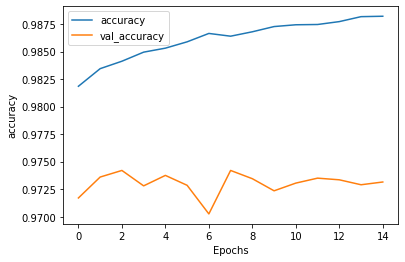

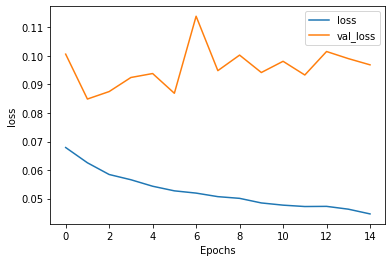

In [ ]:
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

### Train model with complete train and validation data

In [ ]:
train_seqs = token_list
train_labels = labels

tokenizer = Tokenizer(oov_token=oov_tok)
tokenizer.fit_on_texts(train_seqs)
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1

train_sequences = tokenizer.texts_to_sequences(train_seqs)
train_padded = pad_sequences(train_sequences, padding=padding_type)
max_length = len(train_padded[0])

le = LabelEncoder()
le.fit(labels)
label_seq = le.transform(labels)

output = []
for v in label_seq:
    output.append([v])

train_label_seq = np.array(output)
print(len(train_label_seq))

class_weights = generate_class_weights(label_seq)

100000


### model training

In [ ]:
num_epochs = 2
history = model.fit(train_padded, train_label_seq, epochs=num_epochs, class_weight=class_weights)

Epoch 1/2
3125/3125 [==============================] - 35s 11ms/step - loss: 0.1578 - accuracy: 0.9477
Epoch 2/2
3125/3125 [==============================] - 34s 11ms/step - loss: 0.0986 - accuracy: 0.9714


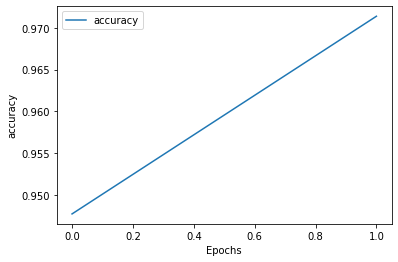

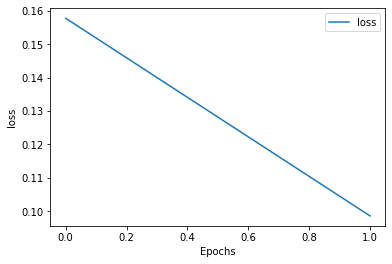

In [ ]:
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

### Test prediction

In [ ]:
filename_test = 'test.csv'
df = pd.read_csv(filename_test).fillna("None")
text = df['NARRATIVE']
token_list = create_tokens(text)
test_seqs = token_list
test_sequences = tokenizer.texts_to_sequences(test_seqs)

In [ ]:
test_padded = pad_sequences(test_sequences, padding=padding_type, maxlen=max_length)

predictions = np.argmax(model.predict(test_padded), axis=1)
print(predictions)

test_seq_predictions = decode_labels(predictions, le)
print(test_seq_predictions)

[0 1 0 ... 0 0 0]
['BTFV' 'BURG' 'BTFV' ... 'BTFV' 'BTFV' 'BTFV']


In [ ]:
print(len(test_seq_predictions))

100000


In [ ]:
test_ids = get_seq_ids(filename_test)

frames = [pd.DataFrame(test_ids), pd.DataFrame(test_seq_predictions)]
output_data= np.concatenate(frames, axis=1)
output_df = pd.DataFrame(output_data)
output_df.to_csv('classify_reports_submission_word_embedding_nn3.csv', index=False,  header=["id","CRIMETYPE"])